Process edges for testing:
- Take in line data from Luis' team
- Translate and rotate

Tests in scope:
- Smoothed inflection point detection
- Downsampling + direct vector comparison
-

Set up basic test data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helpers
import os 

%matplotlib inline

EUCL_NOSAMPLES = 1000
SMOOTHING_FACTOR = 30

X = np.arange(0,10,0.01)+0.34
Y = np.sin(X) + 0.1 * np.sin(X**2+3) + 1
testdata = np.array([X,Y]).T

In [72]:
def axis_align(inputdata):
    # Translate leftermost point to the origin
    translateddata = inputdata - inputdata[0]
    
    # Find an assumed "straight edge" line: 
    # straight line between first and last points
    leftpoint = translateddata[0]
    rightpoint = translateddata[-1]
    slope = (rightpoint[1] - leftpoint[1]) / (rightpoint[0] - leftpoint[0])
    
    # NOTE: can we get c,s more smartly?
    theta = np.arctan(slope)
    c, s = np.cos(theta), np.sin(theta)
    rotationmatrix = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    
    newdata =  translateddata * rotationmatrix
    # plt.scatter(newdata[:,0], newdata[:,1])
    
    scalefactor = newdata[-1,0]
    #print(scalefactor)
    newdata[:,0] = newdata[:,0] / scalefactor
    
    return newdata
    
aligned_data = axis_align(testdata)
aligned_data

matrix([[ 0.        ,  0.        ],
        [ 0.00089423,  0.0097614 ],
        [ 0.00178905,  0.01946875],
        ..., 
        [ 0.99748527,  0.04687478],
        [ 0.99873286,  0.02433138],
        [ 1.        ,  0.        ]])

We have processed lines.

Find locations of juts by smoothing locally (keep as variable smoothing parameter for now)

[ 0.15423938  0.43085204  0.4715077   0.47787571  0.73769031]


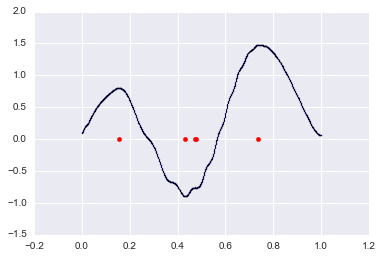

In [61]:
def _kernel_smoother(linedata, pointref, d):
    # Return the smoothed value of f(linedata[pointref])
    
    # Kernel average smoother: take the d nearest points on either side and use their f values
    # as a weighted average for f(x).
    leftlim = max(0, pointref - d)
    rightlim = min(len(linedata), pointref + d)

    weightwindow = np.concatenate( [np.array([(i+1) for i in range(pointref-leftlim)]),
                                   np.array([(d-i) for i in range(rightlim-pointref)])])
    weightwindow = weightwindow / np.sum(weightwindow)
    
    #print(np.sum(weightwindow)
    vals = linedata[leftlim: rightlim][:,1]
    #print(vals.shape, weightwindow.shape)
    #print(vals)
    fx = np.sum(np.multiply(np.squeeze(vals), weightwindow))
    #print(fx)
    return fx

def smooth(linedata):
    Xsmooth = np.array(linedata[:,0]).flatten()
    Ysmooth = [_kernel_smoother(linedata, i, SMOOTHING_FACTOR) for i in range(len(linedata))]
    testdata = np.array([Xsmooth, Ysmooth]).T
    return testdata

def inflection_anal(linedata):
    smoothed = smooth(linedata)
    gradients = np.gradient(smoothed[:,1])

    inflectionmask = [(gradients[i] * gradients[i+1] <= 0) for i in range(len(gradients)-1)]
    
    inflectionrefs = [i for i in range(len(inflectionmask)) if inflectionmask[i]]
    inflectionpoints = smoothed[inflectionrefs,0]
    
    return inflectionrefs, inflectionpoints

smoothed_data = smooth(aligned_data)
inflectionrefs, inflectionpoints = inflection_anal(aligned_data)
print(inflectionpoints)
plt.scatter(smoothed_data[:,0], smoothed_data[:,1], s=1)
plt.scatter(inflectionpoints,[0]*len(inflectionpoints), color='r')


In [62]:
def msdev(linedata):
    total = np.multiply(linedata[:,1], linedata[:,1])
    return np.sum(total)/len(linedata)

msdev(aligned_data)


0.63354434472063337

In [63]:
inputcsv = np.genfromtxt('sample_csv/74584_MS-DAR-00125-000-00073_north.csv', delimiter=',')
inputcsv = inputcsv[1:,(1,2)]
print(inputcsv.shape)

inputcsv.sort(0)

aligned_data = axis_align(inputcsv)

# plt.scatter(inputcsv[:,0],inputcsv[:,1])
# plt.scatter(aligned_data[:,0], aligned_data[:,1])

(3792, 2)


In [64]:
def get_aligneddata(filename):
    inputcsv = np.genfromtxt(filename, delimiter=',')
    inputcsv = inputcsv[1:,(1,2)]
    inputcsv.sort(0)
    aligned_data = axis_align(inputcsv)
    return aligned_data

def get_msdev(filename):
    return msdev(aligned_data)

In [65]:
for i in os.listdir("sample_csv"):
    name = "sample_csv/" + i
    print(name, msdev(get_aligneddata(name)))

sample_csv/74584_MS-DAR-00125-000-00073_north.csv 465.703029291
sample_csv/74584_MS-DAR-00125-000-00073_south.csv 6.8097390376
sample_csv/74584_MS-DAR-00125-000-00073_west.csv 3408.17920444
sample_csv/76748_MS-DAR-00053-00001-000-00118_north.csv 3.19860339829
sample_csv/76748_MS-DAR-00053-00001-000-00118_south.csv 528.912322452
sample_csv/76748_MS-DAR-00053-00001-000-00118_west.csv 0.0
sample_csv/77726_MS-DAR-00205-00001-000-00096_north.csv 1.96121793027
sample_csv/77726_MS-DAR-00205-00001-000-00096_south.csv 9820.61101075


3792 3699


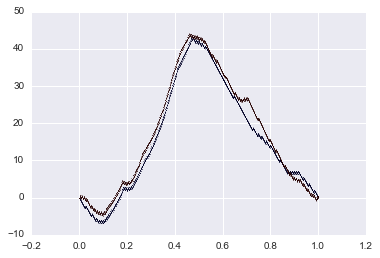

In [66]:
al1 = get_aligneddata("sample_csv/74584_MS-DAR-00125-000-00073_north.csv")
plt.scatter(al1[:,0], al1[:,1], s=0.1)

al2 = get_aligneddata("sample_csv/76748_MS-DAR-00053-00001-000-00118_south.csv")
plt.scatter(al2[:,0], al2[:,1], s=0.1, c='r')

print(len(al1), len(al2))

In [67]:
def downsample(frame, n_chunks=EUCL_NOSAMPLES):
    n_points = frame.shape[0]
    chunk_size = int(n_points / n_chunks)  # TODO: We are throwing away any the last chunk if it doesn't fit.
    
    X = np.arange(0,1,1/n_chunks)
    i=20
    #print([np.multiply((i/n_chunks <= frame[:,0]),(frame[:,0] < (i+1)/n_chunks))])
    Y = [np.mean(frame[:,1][np.multiply((i/n_chunks <= frame[:,0]),(frame[:,0] < (i+1)/n_chunks))]) for i in range(n_chunks)]
    downsampled = np.array([X,Y]).T
    
    return downsampled

al1 = get_aligneddata("sample_csv/74584_MS-DAR-00125-000-00073_north.csv")
al1 = downsample(al1)
print(al1)

[[ 0.         -0.0399778 ]
 [ 0.001      -0.18989453]
 [ 0.002      -0.29983347]
 ..., 
 [ 0.997       0.29983347]
 [ 0.998       0.18323157]
 [ 0.999       0.06662966]]


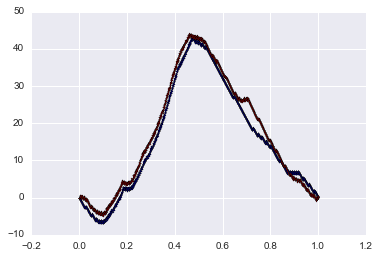

In [68]:
al1 = get_aligneddata("sample_csv/74584_MS-DAR-00125-000-00073_north.csv")
al2 = get_aligneddata("sample_csv/76748_MS-DAR-00053-00001-000-00118_south.csv")
plt.scatter(al1[:,0], al1[:,1], s=1)
plt.scatter(al2[:,0], al2[:,1], s=1, c='r')

al1 = downsample(al1)
al2 = downsample(al2)

plt.scatter(al1[:,0], al1[:,1], s=1)
plt.scatter(al2[:,0], al2[:,1], s=1, c='r')

In [69]:
def eucl_distance(line1, line2):
    line1 = downsample(line1)
    line2 = downsample(line2)
    diff = np.array([line1[:,0],(line1-line2)[:,1]]).T
    
    totdiff = np.sum(np.abs(diff[:,1])) / EUCL_NOSAMPLES
    
    return totdiff
    
eucl_distance(al1, al2)

2.1066660207196248

In [70]:
print(inflection_anal(al1))
print(inflection_anal(al2))

([89, 480], array([ 0.089,  0.48 ]))
([90, 473], array([ 0.09 ,  0.473]))


In [13]:
yvalues = []
for i in os.listdir("sample_csv"):
    name = "sample_csv/" + i
    y = get_aligneddata(name)
    #print(i)
    y = downsample(y)
    #print(np.sum(np.isnan(y)))
    y[np.isnan(y)] = 0
    yvalues.append(np.array(y[:,1]))
    
yvalues.append(np.zeros(1000))

#totaldata = np.vstack(yvalues)
#print(yvalues.shape)
#from sklearn.metrics.pairwise import euclidean_distances
#pd.DataFrame(euclidean_distances(totaldata))

/Users/markostamenovic/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [14]:
print(len(yvalues[0]))
totaldata = np.vstack(yvalues)
print(totaldata.shape)

from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
pd.DataFrame(euclidean_distances(totaldata))

1000
(9, 1000)


,0,1,2,3,4,5,6,7,8
0,0.000000,624.401847,2600.071607,646.593987,75.545766,683.882212,714.595456,2453.989822,683.882212
1,624.401847,0.000000,2136.117857,70.062260,669.280699,82.524152,119.439650,2952.149153,82.524152
2,2600.071607,2136.117857,0.000000,2147.582694,2656.344631,2095.573306,2093.357085,4935.807227,2095.573306
3,646.593987,70.062260,2147.582694,0.000000,692.030446,56.519236,74.898389,2968.654566,56.519236
4,75.545766,669.280699,2656.344631,692.030446,0.000000,731.263372,761.521395,2394.394794,731.263372
5,683.882212,82.524152,2095.573306,56.519236,731.263372,0.000000,44.219882,3018.559775,0.000000
6,714.595456,119.439650,2093.357085,74.898389,761.521395,44.219882,0.000000,3038.090589,44.219882
7,2453.989822,2952.149153,4935.807227,2968.654566,2394.394794,3018.559775,3038.090589,0.000000,3018.559775
8,683.882212,82.524152,2095.573306,56.519236,731.263372,0.000000,44.219882,3018.559775,0.000000


In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(4)
kmeans.fit(totaldata)
kmeans.predict(totaldata)

array([1, 3, 0, 3, 1, 3, 3, 2, 3], dtype=int32)

In [55]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, n_iter=200)
np.set_printoptions(suppress=True)
#model.fit_transform(totaldata)

In [56]:
totaldata

array([[-0.0399778 , -0.18989453, -0.29983347, ...,  0.29983347,
         0.18323157,  0.06662966],
       [-0.01166612, -0.05541405, -0.08749586, ...,  0.08749586,
         0.0534697 ,  0.01944353],
       [-0.88730739, -3.10557588, -5.21293094, ...,  4.76489604,
         3.10557588,  1.33096109],
       ..., 
       [-0.00903558, -0.03666611, -0.05774913, ...,  0.05774913,
         0.03574946,  0.01374979],
       [ 0.29831407,  0.51299271,  0.21788923, ..., -0.07723918,
         0.23383538,  0.16394638],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [57]:
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1], [4,3,2], [6,4,3]])
model.fit_transform(X)

array([[ 0.00017535,  0.00004024],
       [ 0.00009796,  0.0002214 ],
       [ 0.00018536, -0.00009534],
       [ 0.000095  , -0.00001444],
       [-0.00000893,  0.000041  ],
       [ 0.00001518,  0.00014461]])

In [58]:
thing = model.fit_transform(totaldata)

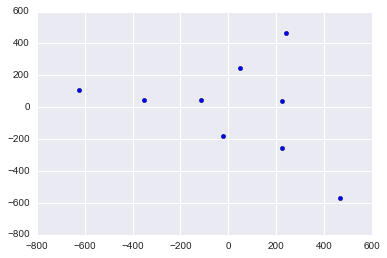

In [59]:
x = [x[0] for x in thing]
y = [x[1] for x in thing]
plt.scatter(x,y)

In [187]:
from itertools import groupby
EUCL_NDPS = 3

def downsample(frame, n_chunks= 10**EUCL_NDPS):
    n_points = frame.shape[0]
    chunk_size = int(n_points / n_chunks)  # TODO: We are throwing away any the last chunk if it doesn't fit.
    meansdict = {np.round(k,3):np.mean([i[0,1] for i in g]) for k,g in groupby(frame, (lambda x: np.round(x[0,0], EUCL_NDPS)))}

    Y = np.zeros(1000)
    for key in meansdict:
        Y[key*1000-1] = meansdict[key]

    return Y


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


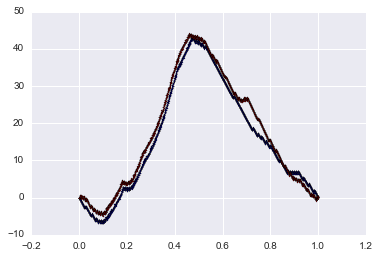

In [188]:
al1 = get_aligneddata("sample_csv/74584_MS-DAR-00125-000-00073_north.csv")
al2 = get_aligneddata("sample_csv/76748_MS-DAR-00053-00001-000-00118_south.csv")
plt.scatter(al1[:,0], al1[:,1], s=1)
plt.scatter(al2[:,0], al2[:,1], s=1, c='r')

al1 = downsample(al1)
al2 = downsample(al2)

In [170]:
yvalues = []

for i in os.listdir("sample_csv"):
    name = "sample_csv/" + i
    y = get_aligneddata(name)
    #print(i)
    y = downsample(y)
    #print(y.shape)
    #print(np.sum(np.isnan(y)))
    #y[np.isnan(y)] = 0
    yvalues.append(np.array(y))
    
yvalues.append(np.zeros(1000))
print(len(yvalues))

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


9


In [166]:
print([len(i) for i in yvalues])
totaldata = np.vstack(yvalues)
print(totaldata.shape)

from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
pd.DataFrame(euclidean_distances(totaldata))

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
(9, 1000)


,0,1,2,3,4,5,6,7,8
0,0.000000,624.422555,2578.312157,646.590947,75.502703,683.878447,714.597479,2453.898600,683.878447
1,624.422555,0.000000,2113.815508,70.045904,669.252250,82.517431,119.427400,2952.081351,82.517431
2,2578.312157,2113.815508,0.000000,2125.206522,2634.067409,2073.691776,2071.324890,4904.275758,2073.691776
3,646.590947,70.045904,2125.206522,0.000000,691.979475,56.511902,74.895048,2968.579840,56.511902
4,75.502703,669.252250,2634.067409,691.979475,0.000000,731.210183,761.473009,2394.344487,731.210183
5,683.878447,82.517431,2073.691776,56.511902,731.210183,0.000000,44.223991,3018.483501,0.000000
6,714.597479,119.427400,2071.324890,74.895048,761.473009,44.223991,0.000000,3038.014901,44.223991
7,2453.898600,2952.081351,4904.275758,2968.579840,2394.344487,3018.483501,3038.014901,0.000000,3018.483501
8,683.878447,82.517431,2073.691776,56.511902,731.210183,0.000000,44.223991,3018.483501,0.000000
